In [503]:
import numpy as np
import pandas as pd
import pymysql
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import requests
import itertools
#from bs4 import BeautifulSoup
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.cross_validation import train_test_split
#import sklearn.cross_validation as cv
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [504]:
conn = pymysql.connect(host='localhost', user='root', password='Sk1ttles', db='nba_stats_prod', autocommit=True)

In [505]:
train = """

select basic.player_id,
       box_view.team,
       box_view.game_hash,
       box_view.game_date,
       box_view.home_away,
       basic.pts,
       basic.minutes_played,
       basic.fga,
       basic.3pa,
       basic.orb,
       basic.trb,
       basic.ast,
       basic.stl,
       basic.blk,
       basic.tov,
       basic.pf,
       adv.turnover_pct,
       adv.usage_pct,
       a_stats.pace,
       adv.offensive_rating,
       reg_avg.fg_a as tot_fg_a,
       reg_avg.3p_a as tot_3p_a,
       reg_avg.ft_a as tot_ft_a,
       reg_avg.reb as tot_reb,
       reg_avg.ast as tot_ast,
       reg_avg.blk as tot_blk,
       reg_avg.stl as tot_stl,
       reg_avg.pf as tot_pf,
       reg_avg.`TO` as tot_to
from (

     select m.game_hash, m.team, m.game_date, m.home_away, lu.season
     from box_scores_map_view as m
     inner join game_date_lookup as lu on m.game_date = lu.day
     where m.game_date < current_date and
           lu.season > 2012 and
           m.home_away = 'Away'
     order by game_date desc

     ) as box_view

inner join(


    select b.game_hash, team.team_id, lu.season
    from box_score_map as b
    inner join game_date_lookup as lu on b.game_date = lu.day
    inner join team_info as team on b.home_team = team.team
    where b.game_date < current_date and
          lu.season > 2012


    ) as away_team on box_view.game_hash = away_team.game_hash

inner join player_team_map as play_m on ( (box_view.team = play_m.team) and (
box_view.season = play_m.season) )
inner join basic_box_stats as basic on ( (box_view.game_hash = basic.game_hash) and (
play_m.player_id = basic.player_id) )
inner join advanced_box_stats as adv on ( (box_view.game_hash = adv.game_hash) and (
play_m.player_id = adv.player_id) )
inner join team_advanced_boxscore_stats as a_stats on ( (box_view.game_hash = a_stats.game_hash) and (box_view.team = a_stats.team) )
left outer join RegularSeasonAverages as reg_avg on ( (basic.player_id = reg_avg.player_id) and (box_view.season-1 = reg_avg.season) )
order by box_view.game_date desc;

"""

In [506]:
df = pd.read_sql(sql=train, con=conn, index_col=None)

In [507]:
def time_convert(minutes_played):
    time_list = minutes_played.split(':')
    try:
        return ((int(time_list[0]) * 60) + int(time_list[1]))
    except ValueError:
        return 0

In [508]:
def concat_drop(df, dummy_var_col, drop_list):
    for field in dummy_var_col:
        df = pd.concat([df, gen_dummby_var(df, field)], axis=1)
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [509]:
def gen_dummby_var(df, column):
    return pd.get_dummies(df[column], drop_first=True)

In [510]:
df.loc[:, 'minutes_played'] = df.loc[:, 'minutes_played'].apply(time_convert)

In [511]:
clean_df = concat_drop(df[df['minutes_played'] >= 720], ['home_away'], [ 'team', 'game_hash','home_away'])

In [512]:
#clean_df.drop('Home', inplace=True, axis=1)
group_df = clean_df.groupby('player_id')
group_df.head()

,player_id,game_date,pts,minutes_played,fga,3pa,orb,trb,ast,stl,...,offensive_rating,tot_fg_a,tot_3p_a,tot_ft_a,tot_reb,tot_ast,tot_blk,tot_stl,tot_pf,tot_to
0,2528795,2018-11-16,9,1502,9,6,0,5,1,1,...,84.0,8.0,4.6,1.1,3.3,1.6,0.3,0.4,2.0,1.2
1,2530781,2018-11-16,8,1100,7,2,0,4,1,0,...,104.0,7.2,2.9,1.6,2.3,2.0,0.2,1.1,1.1,1.2
2,2531211,2018-11-16,6,1223,8,6,0,2,0,0,...,81.0,11.0,7.1,1.5,4.3,1.6,0.5,0.6,2.2,1.0
3,2580783,2018-11-16,25,1878,13,5,2,4,8,3,...,156.0,10.5,5.4,2.7,3.2,6.6,0.3,0.9,2.3,1.6
4,3133987,2018-11-16,23,1787,16,4,0,3,6,2,...,110.0,14.0,5.8,2.0,3.9,5.2,0.4,0.8,1.9,3.1
5,4063539,2018-11-16,16,1908,11,0,6,12,0,1,...,135.0,5.5,0.2,1.6,5.4,0.7,1.2,0.4,2.0,1.1
6,5353041,2018-11-16,5,1345,4,3,1,3,0,1,...,85.0,2.5,1.7,0.6,2.0,1.6,0.2,0.5,1.8,0.6
7,5353810,2018-11-16,11,1457,10,5,1,6,2,0,...,105.0,10.8,5.4,2.6,6.6,2.0,0.4,0.8,2.3,1.4
8,5354099,2018-11-16,3,894,3,0,2,5,1,0,...,100.0,3.7,0.0,0.9,7.4,0.5,0.7,0.4,2.4,0.8
9,5357002,2018-11-16,9,1247,8,2,1,3,0,0,...,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [513]:
clean_df = clean_df.fillna(0)

In [514]:
x = clean_df.loc[:, 'minutes_played':]
y = clean_df.loc[:, 'pts']

In [515]:
X_train, X_test, y_train, y_test = train_test_split(clean_df.loc[:, 'minutes_played':], clean_df.loc[:, 'pts'], test_size=.33)

In [516]:
lm = LinearRegression()

In [517]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [518]:
predictions = lm.predict(X_test)

Text(0,0.5,'Predicted Y')

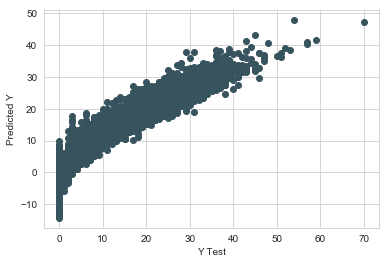

In [519]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

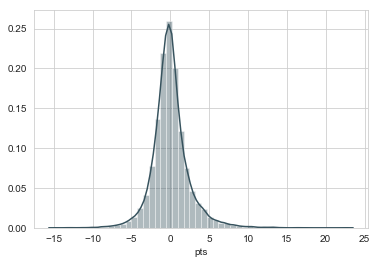

In [520]:
sns.distplot((y_test-predictions),bins=50);

In [521]:
coeffecients = pd.DataFrame(lm.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.003348
fga,0.708709
3pa,0.066035
orb,-0.406338
trb,0.045766
ast,-0.297943
stl,0.021653
blk,0.034114
tov,-0.052213
pf,0.009658


In [522]:
lm.score(X_test, y_test)

0.90229893129953709

In [349]:
### Experimenting with Lasso regression

In [350]:
lasso = Lasso(alpha=0.0023101297000831605)  #Home: 0.00174333 - 0.00221222

In [351]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.0023101297000831605, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [352]:
predictions = lasso.predict(X_test)

Text(0,0.5,'Predicted Y')

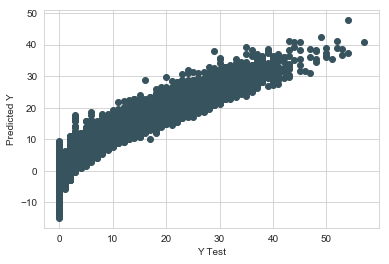

In [353]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

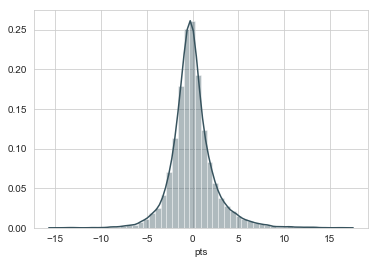

In [354]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.distplot(y_test-predictions, bins=50)

In [355]:
lasso.score(X_test, y_test)

0.90172439306968766

In [122]:
coeffecients = pd.DataFrame(lasso.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.003591
fga,0.718559
3pa,0.058154
orb,-0.439371
trb,0.049132
ast,-0.317083
stl,0.023111
blk,0.050386
tov,-0.046173
pf,-0.000130


In [123]:
#### Using Lasso cross-validation model

In [124]:
lasso_cv = LassoCV()

In [125]:
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [126]:
predictions_cv = lasso_cv.predict(X_test)

Text(0,0.5,'Predicted Y')

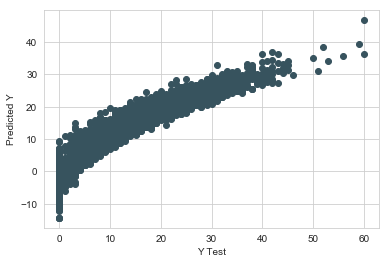

In [127]:
plt.scatter(y_test,predictions_cv)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

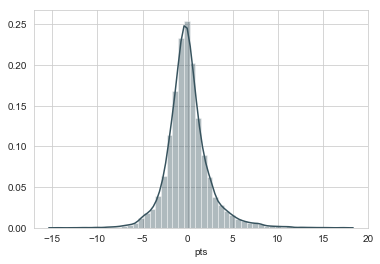

In [128]:
sns.distplot(y_test-predictions, bins=50)

In [129]:
lasso_cv.score(X_test, y_test)

0.87700721165817674

In [130]:
coeffecients = pd.DataFrame(lasso.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.003591
fga,0.718559
3pa,0.058154
orb,-0.439371
trb,0.049132
ast,-0.317083
stl,0.023111
blk,0.050386
tov,-0.046173
pf,-0.000130


In [131]:
### optimizing alpha value in Lasso regression

In [479]:
alphas = np.logspace(-4, -1, 100)
#alphas = np.linspace(.001, .999, 100) #0.00464159
#alphas

In [480]:
scores = np.empty_like(alphas)

In [481]:
for i, a in enumerate(alphas):
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    scores[i] = lasso.score(X_test, y_test)

In [482]:
lasso_cv = LassoCV(alphas=alphas)
lasso_cv.fit(x, y)
cv_score = lasso_cv.score(x, y)
cv_alpha = lasso_cv.alpha_
cv_alpha, cv_score, lasso_cv.coef_, lasso_cv.intercept_

(0.0043287612810830618,
 0.90283989252309094,
 array([ 0.00337929,  0.70510393,  0.0699321 , -0.40753868,  0.04906128,
        -0.30244792,  0.0101565 ,  0.01438616, -0.04100197,  0.00536242,
         0.08054091,  0.27864505,  0.06710806,  0.09539733, -0.08283271,
         0.01177064,  0.47069131,  0.03127091, -0.00872212,  0.10822813,
         0.        , -0.10823592, -0.        , -0.00195669, -0.00854928]),
 -22.864838961381707)

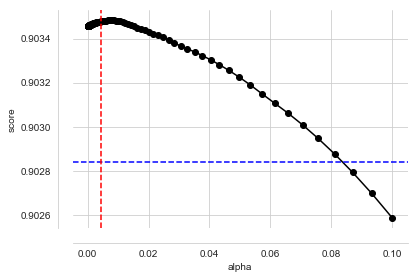

In [483]:
plt.plot(alphas, scores, '-ko')
plt.axhline(cv_score, color='b',ls='--')
plt.axvline(cv_alpha, color='r', ls='--')
plt.xlabel('alpha')
plt.ylabel('score')
plt.xscale('linear')
sns.despine(offset=15)

In [484]:
predictions = lasso_cv.predict(X_test)

In [485]:
lasso_cv.score(x, y)

0.90283989252309094

In [486]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.61789168121
MSE: 5.40210977036
RMSE: 2.3242439137


In [487]:
np.amax(scores)

0.90348275694401348

In [488]:
np.take(alphas, np.argmax(scores))

0.0075646332755462909

Text(0,0.5,'Predicted Y')

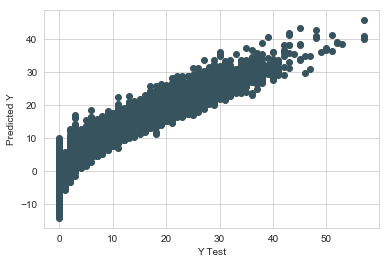

In [489]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
